Source: 
* https://blog.paperspace.com/dreambooth-stable-diffusion-tutorial-part-2-textual-inversion/
* https://huggingface.co/runwayml/stable-diffusion-v1-5
* https://huggingface.co/docs/diffusers/v0.3.0/en/api/pipelines/stable_diffusion#diffusers.StableDiffusionPipeline.__call__.num_inference_steps

In [ ]:
!pip install -qq accelerate tensorboard ftfy
!pip install -qq -U transformers
!pip install -qq -U diffusers
!pip install -qq bitsandbytes
!pip install gradio

In [1]:
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
#from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer


## Instantiate helper function
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [2]:
imgs = list(map(lambda pth: Image.open(f"./inputs_textual_inversion/{pth}"), os.listdir('./inputs_textual_inversion')))

In [ ]:
image_grid(imgs, 1, len(imgs))

In [2]:
concept_name = "Mikhail_Dzigen_Menshikov"

#`initializer_token` is a word that can summarise what your 
#new concept is, to be used as a starting point
initializer_token = "man" #@param {type:"string"}

# `what_to_teach`: what is it that you are teaching? `object` enables you to teach the model a new object to be used,
# `style` allows you to teach the model a new style one can use.
what_to_teach = "object" #@param ["object", "style"]

# `placeholder_token` is the token you are going to use to represent your new concept (so when you prompt the model, 
# you will say "A `<my-placeholder-token>` in an amusement park"). We use angle brackets to differentiate a token from other words/tokens, to avoid collision.
placeholder_token = f'<{concept_name}>'

In [ ]:

    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a photo of the clean {}",
    "a photo of a nice {}",
    "a photo of the nice {}",
    "a photo of a cool {}",

In [3]:
#Setup the prompt templates for training 
imagenet_templates_small = [
    "a dark photo of the {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "the photo of a {}",
     "a cropped photo of the {}",
    "a photo of a {}",
    "a rendering of a {}",
    "a rendering of {} centered in frame, facing camera",
    "a cropped photo of {}",
    "{}",
    "a close-up photo of {}, 85mm lens, f8, photography",
    "a headshot of {}",
    "the face of {}",
    "a bright photo of {}",
    "a cropped photo of {}",
    "a photo of {} smiling",
    "{}, 85mm lens,f8, photography, ultra details, natural light, dark background, photo",
    "a good photo of {}",
    "a photo of {} looking at the camera",
    "a close-up photo of {}",
    "a rendition of {}",
    "a mid body photo of {} facing camera",
    "a beautiful photo of {} facing camera",
    "a good photo of a {}",
    "a cool photo of {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a photo of the clean {}",
    "a photo of a nice {}",
    "a photo of the nice {}",
    "a photo of a cool {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

In [7]:
#@title Setup the dataset
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [8]:
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}

In [9]:
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer")

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

In [10]:
#@title Get token ids for our placeholder and initializer token. This code block will complain if initializer string is not a single token
# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

In [11]:
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder",

)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae",

)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet",

)

In [12]:
text_encoder.resize_token_embeddings(len(tokenizer))

token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In [13]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

In [4]:
save_path = '/home/dzigen/Desktop/ITMO/sem1/ImgGen/Лабы/lab5/inputs_textual_inversion'

In [15]:
train_dataset = TextualInversionDataset(
      data_root=save_path,
      tokenizer=tokenizer,
      size=512,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)

def create_dataloader(train_batch_size=16):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)



/tmp/ipykernel_26616/1072415768.py:34: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  "linear": PIL.Image.LINEAR,
/tmp/ipykernel_26616/1072415768.py:35: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  "bilinear": PIL.Image.BILINEAR,
/tmp/ipykernel_26616/1072415768.py:36: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  "bicubic": PIL.Image.BICUBIC,
/tmp/ipykernel_26616/1072415768.py:37: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  "lanczos": PIL.Image.LANCZOS,


In [16]:
noise_scheduler = DDPMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000,
)

In [5]:
hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 1000,
    "train_batch_size": 1,
    "gradient_accumulation_steps": 1,
    "seed": 42,
    "output_dir": f'./data/{concept_name}-concept',
}

In [18]:
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        # distributed_type='MULTI_GPU' 
        # distribute_type: Accelerate.DistributedType.MULTI_GPU
        # fp16=True,
        cpu=True,
    )

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )


    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    # Move vae and unet to device
    vae.to(accelerator.device)
    unet.to(accelerator.device)

    # Keep vae and unet in eval model as we don't train these
    vae.eval()
    unet.eval()

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"]).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline(
            text_encoder=accelerator.unwrap_model(text_encoder),
            vae=vae,
            unet=unet,
            tokenizer=tokenizer,
            scheduler=PNDMScheduler(
                beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
            ),
            safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
            feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"),
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
        learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
        torch.save(learned_embeds_dict, os.path.join(output_dir, "learned_embeds.bin"))

In [ ]:
import accelerate

accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet), num_processes=1)

### Inference

In [6]:
pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    # "downloaded_embedding",
    #torch_dtype=torch.float16,
).to("cpu")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/dzigen/miniconda3/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [12]:
import gc
gc.collect()

17514

  0%|          | 0/30 [00:00<?, ?it/s]

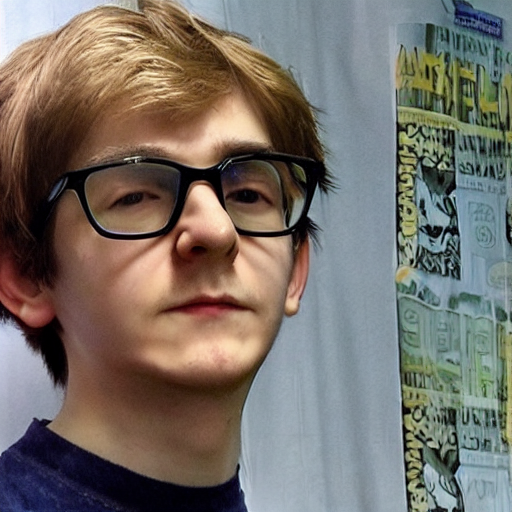

In [16]:
#@title Run the Stable Diffusion pipeline
#@markdown Don't forget to use the placeholder token in your prompt

prompt = f"a good photo of {placeholder_token}, high quality, realism" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

# prevent safety checking
def dummy(images, **kwargs):
    return images, False
pipe.safety_checker = dummy

all_images = [] 
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=30, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid 

In [18]:
all_images[0].save("./asd.png")

In [2]:
tokenizer = CLIPTokenizer.from_pretrained(
    "/home/dzigen/Desktop/ITMO/sem1/ImgGen/Лабы/lab5/Mikhail_Dzigen_Menshikov-concept",
    subfolder="tokenizer")

In [7]:
tokenizer.all_special_tokens

['<|startoftext|>', '<|endoftext|>']